# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Image 7

In [40]:
image_path:str = "test_images/7.M.jpg"

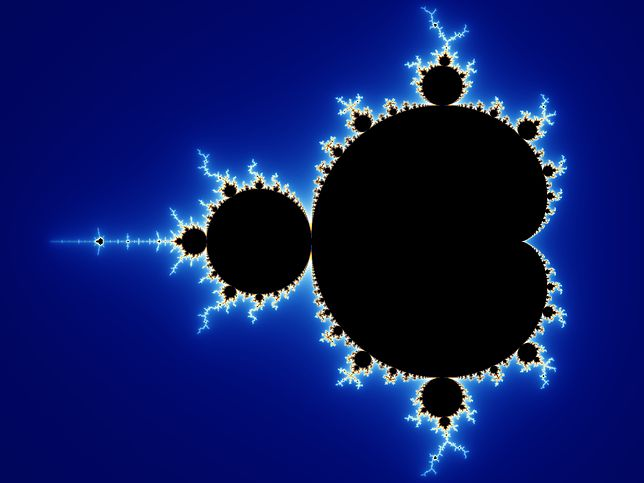

In [41]:
image = Image.open(image_path)
image

In [42]:
prompt :str = "<image>\nDescribe this picture concisely."

In [43]:
response(image_path,prompt)

Generated text:

The image features a detailed picture depicts an artistic rendition of the intricate and blue patterns of interconnected mand patterns created by connecting celestial star blue blue designs in black hole star celestial celestial patterns formed using various celestial patterns resembling star celestial patterns and shapes resembling formed with multiple resembling shapes and shapes and shades resembling resembling circles reminiscent shapes within a complicated of black void of light and shades, shapes within a dark shapes and shades and shades of black circles and shades of black and shades of black and shades of black and shades of negative signs of circles of matter of dark shapes of black and shades of blue and bright blue and shades of black and shades of electric of shapes, shapes and shades of shapes and shades of a of black and sizes of black and shades of shapes within shapes, shapes and light and shades of shapes and shades of circles on shapes and forms on a

In [44]:
prompt :str = "<image>\nThis image is actually related to a mathematical concept. Do you know which one?"

In [45]:
response(image_path,prompt)

Generated text:

The image represents a visual depiction is related to the concept: of two is associated to the mathematical artwork, in question of the " mathematical set of the "fract
set theory of a Droduser user of an intriguing a limit of the Cantor
to the Cantor
 pictureor
of the Cantor
 pictureor
of a recursive

Cor
Cor
The imageor
The imageor
The image of a Koch
Thisor
The image Cantor
C
The image Cantor
The image Cantor
The image Cantor
The image Cantor
The image Cantor
The image of a Cantor
The image Cantor's set of a Cantor
The Droor
The Cantor
The Cantor
The Cantor
The Cantor
The Cantor
The Cantor
The Cantor Set of the Cantor Set
The Cantor's Set of a
The Cantor's
The Cantor
The Cantor
The Cantor's diagonalor
The Cantor's Di
The Cantor Set
The Cantor's Di
The Cantor Set
The Cantor's Di
C
The Cantor's Set
The Cantor's Set
C
The Cantor's Di
The Cantor Set
The Cantor's Di
The Cantor's Di
The Cantor's Di
The Cantor's Set:
C
Theodoreor's Di
The Cantor Set
C's Set
The Cantor's Di